<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

#!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#!unzip "/content/stuff_annotations_trainval2017.zip"

!pip install transformers

--2022-06-25 20:12:53--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.175.17
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.175.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  76.0MB/s    in 3.2s    

2022-06-25 20:12:57 (76.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
Looking in indexes: https://pypi.org/simple, https://us-pytho

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms

In [4]:
dataDir='/content'

## Annotations from instances of objects train/val

aFile_inst_train='{}/annotations/instances_train2017.json'.format(dataDir) ## Annotation file - train
aFile_inst_val='{}/annotations/instances_val2017.json'.format(dataDir) ## Annotation file - validation

coco_inst_train = COCO(aFile_inst_train)
coco_inst_val = COCO(aFile_inst_val)

loading annotations into memory...
Done (t=20.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [6]:
## Annotations from "stuff" train/val

#aFile_stuff_train='{}/annotations/stuff_train2017.json'.format(dataDir) ## Annotation file - train
#aFile_stuff_val='{}/annotations/stuff_val2017.json'.format(dataDir) ## Annotation file - validation

#coco_stuff_train = COCO(aFile_stuff_train)
#coco_stuff_val = COCO(aFile_stuff_val)

In [ ]:
# Check which GPU we are using
#!nvidia-smi

In [ ]:
#if torch.cuda.is_available(): 
#   dev = "cuda:0"
#else: 
#   dev = "cpu"
#device = torch.device(dev)
#print('Using {}'.format(device))

# Implementação do MyDataset

In [5]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco, transformations, num_cats: int):
    self.img_ids = img_ids
    self.coco = coco
    self.transformations = transformations
    self.num_cats = num_cats
  
  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    
    ## Inputs
    imgs_info = self.coco.loadImgs(self.img_ids)
    imgs_url = [imgs_info[i]['coco_url'] for i in range(len(imgs_info))]
    imgs = [io.imread(imgs_url[i]) for i in range(len(imgs_url))]
    self.inputs = [self.transformations(i) for i in imgs]

    ## Targets
    targets = torch.tensor([])

    for id in self.img_ids:
      ann_id = self.coco.getAnnIds(id)
      anns = self.coco.loadAnns(ann_id)
      cat_idxs = [anns[i]['category_id'] for i in range(len(anns))]
      tgt = torch.zeros(self.num_cats)
      print(id, cat_idxs)
      #tgt[cat_idxs] = 1
      #targets = torch.cat((targets, tgt), dim=0)
    
    #self.targets = targets

    return self.inputs[idx]#, self.targets[idx]

#Assert do MyDataset

In [16]:
## Dataset

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset(img_ids=dummy_image_ids, coco=coco_inst_train, transformations=transformations, num_cats=80)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_input = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_input = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_input = torch.cat((correct_first_batch_input, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_input = correct_first_batch_input.view(5, 3, 224, 224)
correct_first_batch_input = torch.FloatTensor(correct_first_batch_input)

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de dataset')

Passou no assert de tamanho do dataset.
391895 [4, 1, 1, 2]
522418 [1, 49, 61, 81]
184613 [21, 21, 21, 21, 21, 28, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 21, 1]
318219 [1, 1, 74, 74, 76, 76, 74, 72, 72, 72, 74]
554625 [72, 72, 1, 1, 1, 72, 74, 74, 76, 76, 76, 72, 74, 74, 1, 1, 72, 74, 76]
391895 [4, 1, 1, 2]
522418 [1, 49, 61, 81]
184613 [21, 21, 21, 21, 21, 28, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 21, 1]
318219 [1, 1, 74, 74, 76, 76, 74, 72, 72, 72, 74]
554625 [72, 72, 1, 1, 1, 72, 74, 74, 76, 76, 76, 72, 74, 74, 1, 1, 72, 74, 76]
391895 [4, 1, 1, 2]
522418 [1, 49, 61, 81]
184613 [21, 21, 21, 21, 21, 28, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 21, 1]
318219 [1, 1, 74, 74, 76, 76, 74, 72, 72, 72, 74]
554625 [72, 72, 1, 1, 1, 72, 74, 74, 76, 76, 76, 72, 74, 74, 1, 1, 72, 74, 76]
391895 [4, 1, 1, 2]
522418 [1, 49, 61, 81]
184613 [21, 21, 21, 21, 21, 28, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 21, 1]
318219 [1, 1, 74, 74, 76, 76, 74, 72, 72,

In [17]:
dummy_dataset[0]

391895 [4, 1, 1, 2]
522418 [1, 49, 61, 81]
184613 [21, 21, 21, 21, 21, 28, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 21, 1]
318219 [1, 1, 74, 74, 76, 76, 74, 72, 72, 72, 74]
554625 [72, 72, 1, 1, 1, 72, 74, 74, 76, 76, 76, 72, 74, 74, 1, 1, 72, 74, 76]


tensor([[[ 2.2438,  2.2438,  2.2438,  ...,  2.2318,  2.2426,  2.2489],
         [ 2.2208,  2.1963,  2.2184,  ...,  2.2028,  2.2267,  2.2318],
         [ 2.1694,  2.0531,  1.8169,  ...,  2.1990,  2.2219,  2.2318],
         ...,
         [ 1.6033,  1.7198,  1.5786,  ...,  0.6182,  0.7660,  0.4410],
         [ 1.5157,  1.4582,  1.2449,  ...,  0.6914,  0.7652,  0.3032],
         [ 1.7455,  1.8786,  1.8238,  ...,  0.6927,  0.7803,  0.6223]],

        [[ 2.4234,  2.4234,  2.4234,  ...,  2.4111,  2.4221,  2.4286],
         [ 2.3980,  2.3835,  2.4267,  ...,  2.4165,  2.4187,  2.4111],
         [ 2.4030,  2.3226,  2.1081,  ...,  2.4126,  2.4138,  2.4111],
         ...,
         [ 1.5421,  1.6756,  1.5356,  ...,  0.2396,  0.3267,  0.0515],
         [ 1.2846,  1.3300,  0.8975,  ...,  0.2977,  0.4154,  0.2050],
         [ 1.6355,  1.8268,  1.8411,  ...,  0.3259,  0.3338,  0.2071]],

        [[ 2.6348,  2.6348,  2.6348,  ...,  2.6226,  2.6336,  2.6400],
         [ 2.6192,  2.6280,  2.6124,  ...,  2

In [ ]:
ids = coco_inst_train.getImgIds()
print(ids[0:5])

[391895, 522418, 184613, 318219, 554625]


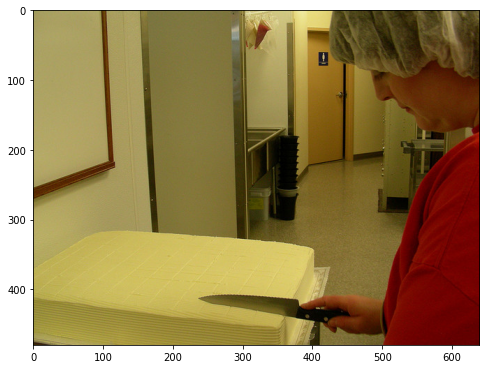

In [ ]:
plt.imshow(dataset[1])
plt.show()

In [ ]:
# Category IDs.
cat_ids = coco_annotation.getCatIds()
len(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
cats

In [ ]:
cat_ids = coco_annotation.getCatIds()
len(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
print(cats[20])

{'supercategory': 'animal', 'id': 22, 'name': 'elephant'}


In [ ]:
cats = coco_annotation.loadCats([157])
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

Categories Names:
['sky-other']


In [ ]:
img_ids = coco_annotation.getImgIds()
img_ids[29]
img_info = coco_annotation.loadImgs(img_ids[29])
img_ids[29]

79841

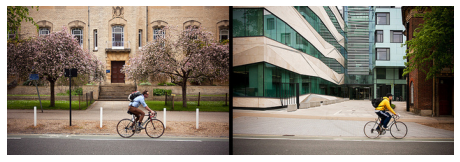

In [ ]:
img_url = img_info[0]["coco_url"]
I = io.imread(img_url)
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
img_id = img_info[0]["id"]
ann_ids = coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)
print(f"Annotations for Image ID {img_id}:")
print(anns)

Annotations for Image ID 497160:
[{'segmentation': [[241.27, 37.95, 324.93, 68.77, 334.61, 78.46, 339.02, 102.23, 331.97, 179.72, 326.69, 201.73, 320.52, 212.3, 303.79, 229.91, 215.74, 286.27, 131.2, 333.82, 101.26, 344.38, 98.62, 332.94, 93.34, 331.18, 78.37, 339.1, 28.18, 267.78, 21.13, 258.09, 28.18, 249.28, 11.45, 230.79, 20.25, 218.46, 14.97, 160.35, 36.98, 134.81, 79.25, 100.47, 175.23, 55.56, 238.63, 37.07]], 'area': 67745.08085, 'iscrowd': 0, 'image_id': 497160, 'bbox': [11.45, 37.07, 327.57, 307.31], 'category_id': 80, 'id': 1128544}]
